# BERT를 활용한 단일 문장 분류를 위한 Trainer 구현하기


[CC BY-NC-ND](https://creativecommons.org/licenses/by-nc-nd/2.0/kr/)

###**콘텐츠 라이선스**

<font color='red'><b>**WARNING**</b></font> : **본 교육 콘텐츠의 지식재산권은 재단법인 네이버커넥트에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다.** 다만, 비영리적 교육 및 연구활동에 한정되어 사용할 수 있으나 재단의 허락을 받아야 합니다. 이를 위반하는 경우, 관련 법률에 따라 책임을 질 수 있습니다.

이번 시간에는 BERT를 활용해, 단일 문장을 분류하는 task를 풀기 위한 Trainer를 살펴보고, 이 중 일부 기능(customized linear scheduler)을 직접 구현해 봅시다.

중간에 있는 MyFunction() 함수를 구현하여 제출해주세요!

In [1]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 13.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 14.1 MB/s eta 0:00:0

In [2]:
import torch
import datasets
import sys

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
# 사용가능한 dataset list 불러오기
dataset_list = datasets.list_datasets()

# dataset list 확인
for datas in dataset_list:
    if 'ko' in datas:
        print(datas)

kor_3i4k
kor_hate
kor_ner
kor_nli
kor_nlu
kor_qpair
kor_sae
kor_sarcasm
squad_kor_v1
squad_kor_v2
AI-it/korean-hate-speech
Jack0508/TED2020_kor
Jack0508/TED2020vi_kor
Jack0508/vi-ko-TED-txt
KETI-AIR/kor_corpora
KETI-AIR/korquad
NikolajW/NPS_nonNormalized-Cased
Sabokou/qg_squad_modified
Sabokou/qg_squad_modified_dev
Sakonii/nepalitext-language-model-dataset
abwicke/koplo
cyko/books
dennlinger/klexikon
huggingartists/aikko
huggingartists/boris-grebenshikov
huggingartists/kojey-radical
huggingartists/krept-and-konan-bugzy-malone-sl-morisson-abra-cadabra-rv-and-snap-capone
huggingartists/lyapis-trubetskoy
huggingartists/max-korzh
imvladikon/hebrew_speech_coursera
imvladikon/hebrew_speech_kan
imvladikon/knesset_meetings_corpus
kowndinya23/bert-dataset
kresnik/zeroth_korean
larcane/ko-WIT
mariosasko/dummy_test
mariosasko/test_multi_dir_dataset
msarmi9/korean-english-multitarget-ted-talks-task
nykodmar/cs_corpora_parliament_processed
poperson1205/mrtydi-v1.1-korean-fixed
roskoN/dailydialog
ro

In [5]:
# nsmc 데이터 로드
dataset = datasets.load_dataset('nsmc') # nsmc, hate, sarcasm

# 데이터셋 구조 확인
print(dataset)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/150000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset nsmc downloaded and prepared to /root/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})


In [6]:
import pandas as pd

In [7]:
# 필요한 데이터인 document와 label 정보만 pandas라이브러리 DataFrame 형식으로 변환
train_data = pd.DataFrame({"document":dataset['train']['document'], "label":dataset['train']['label'],})
test_data = pd.DataFrame({"document":dataset['test']['document'], "label":dataset['test']['label'],})

In [8]:
# 데이터셋 갯수 확인
print('학습 데이터셋 : {}'.format(len(train_data)))
print('테스트 데이터셋 : {}'.format(len(test_data)))

학습 데이터셋 : 150000
테스트 데이터셋 : 50000


In [9]:
# 데이터셋 내용 확인
train_data[:5]

,document,label
0,아 더빙.. 진짜 짜증나네요 목소리,0
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [10]:
test_data[:5]

,document,label
0,굳 ㅋ,1
1,GDNTOPCLASSINTHECLUB,0
2,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [11]:
# 데이터 중복을 제외한 갯수 확인
print("학습데이터 : ",train_data['document'].nunique()," 라벨 : ",train_data['label'].nunique())
print("데스트 데이터 : ",test_data['document'].nunique()," 라벨 : ",test_data['label'].nunique())

# 중복 데이터 제거
train_data.drop_duplicates(subset=['document'], inplace= True)
test_data.drop_duplicates(subset=['document'], inplace= True)

# 데이터셋 갯수 확인
print('중복 제거 후 학습 데이터셋 : {}'.format(len(train_data)))
print('중복 제거 후 테스트 데이터셋 : {}'.format(len(test_data)))

학습데이터 :  146183  라벨 :  2
데스트 데이터 :  49158  라벨 :  2
중복 제거 후 학습 데이터셋 : 146183
중복 제거 후 테스트 데이터셋 : 49158


In [12]:
import numpy as np

In [13]:
# null 데이터 제거
train_data['document'].replace('', np.nan, inplace=True)
test_data['document'].replace('', np.nan, inplace=True)
train_data = train_data.dropna(how = 'any')
test_data = test_data.dropna(how = 'any')

print('null 제거 후 학습 데이터셋 : {}'.format(len(train_data)))
print('null 제거 후 테스트 데이터셋 : {}'.format(len(test_data)))

null 제거 후 학습 데이터셋 : 146182
null 제거 후 테스트 데이터셋 : 49157


In [14]:
print(train_data['document'][0])
print(train_data['label'][0])

아 더빙.. 진짜 짜증나네요 목소리
0


학습 문장 최대 길이 : 146
학습 문장의 평균 길이 : 35.981338331668745


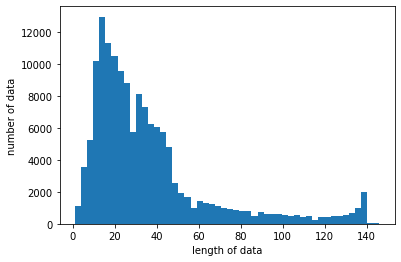

In [15]:
from matplotlib import pyplot as plt

#학습 리뷰 길이조사
print('학습 문장 최대 길이 :',max(len(l) for l in train_data['document']))
print('학습 문장의 평균 길이 :',sum(map(len, train_data['document']))/len(train_data['document']))

plt.hist([len(s) for s in train_data['document']], bins=50)
plt.xlabel('length of data')
plt.ylabel('number of data')
plt.show()

In [16]:
# Store the model we want to use
from transformers import AutoModel, AutoTokenizer, BertTokenizer
MODEL_NAME = "klue/bert-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [17]:
tokenized_train_sentences = tokenizer(
    list(train_data['document']),
    return_tensors="pt",
    padding=True,
    truncation=True,
    add_special_tokens=True,
    )

In [18]:
print(tokenized_train_sentences[0])
print(tokenized_train_sentences[0].tokens)
print(tokenized_train_sentences[0].ids)
print(tokenized_train_sentences[0].attention_mask)

Encoding(num_tokens=142, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
['[CLS]', '아', '더', '##빙', '.', '.', '진짜', '짜증', '##나', '##네', '##요', '목소리', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[

In [19]:
tokenized_test_sentences = tokenizer(
    list(test_data['document']),
    return_tensors="pt",
    padding=True,
    truncation=True,
    add_special_tokens=True,
    )

In [20]:
train_label = train_data['label'].values
test_label = test_data['label'].values

In [21]:
class SingleSentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [22]:
train_dataset = SingleSentDataset(tokenized_train_sentences, train_label)
test_dataset = SingleSentDataset(tokenized_test_sentences, test_label)

# Custom Trainer 구현하기

- Pytorch Lighting, Transformers 등의 라이브러리에서는 딥러닝 모델의 학습 및 추론을 관리하기 위한 Trainer 클래스를 제공하는 경우가 많습니다.
- 이러한 Trainer를 직접 구현해 가면서 딥러닝 모델의 학습 과정을 보다 자세하게 살펴봅시다!


### 학습을 위한 Training Arguments를 관리하는 Dictionary 만들기

In [23]:
from typing import Dict, Any


hparams = {'output_dir':'./results',          # output directory
    'num_train_epochs':1,              # total number of training epochs
    'per_device_train_batch_size':32,  # batch size per device during training
    'per_device_eval_batch_size':12,   # batch size for evaluation
    'warmup_steps':500,                # number of warmup steps for learning rate scheduler
    'weight_decay':0.01,               # strength of weight decay
    'logging_steps':500,
    'lr':0.0001}

### 간단한 Trainer 클래스 만들기

- Trainer 클래스의 초기화를 위해 Hypermareter dictionary, 모델, 학습 데이터셋 및 Optimizer를 전달합니다.
- 학습 및 추론을 담당하는 함수인 "train()"과 "evaluate()"가 구현되어 있습니다.

In [24]:
from tqdm import tqdm
from torch.optim import Adam
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


class MyTrainer:
    def __init__(self, hparams:Dict[str,Any], model, train_dataset, optimizer):
        self.hparams = hparams
        self.model = model
        self.train_dataset = train_dataset
        self.train_loader = DataLoader(self.train_dataset, batch_size=self.hparams['per_device_train_batch_size'],shuffle=True)
        self.optimizer = optimizer
    
    def train(self):
        for epoch in range(self.hparams['num_train_epochs']):
            self._run_epoch()
    
    def _run_epoch(self):
        self.model.train()
        for idx,batch in enumerate(tqdm(self.train_loader)):
            batch = {k:v.to(device) for k,v in batch.items()}
            # Transformers 라이브러리의 BertForSequenceClassification 클래스에서는 모델의 forward() 함수에 "labels"를 함께 전달하면 CrossEntropy loss를 반환합니다.
            loss = self.model(**batch)[0]
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            if idx%self.hparams['logging_steps']==0: print(loss)
    
    def evaluate(self, eval_dataset):
        eval_loader = DataLoader(self.train_dataset, batch_size=self.hparams['per_device_eval_batch_size'],shuffle=True)
        preds = []
        labels = []
        self.model.eval()
        for idx,batch in enumerate(tqdm(eval_loader)):
            batch = {k:v.to(device) for k,v in batch.items()}
            with torch.no_grad():
                output = self.model(**batch)[1]
                prediction = torch.argmax(output,dim=1).cpu().numpy().tolist()
                preds.extend(prediction)
                labels.extend(batch['labels'].cpu().numpy().tolist())
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
        acc = accuracy_score(labels, preds)
        return {
            'accuracy': acc,
            'f1': f1,
            'precision': precision,
            'recall': recall
        }


model = BertForSequenceClassification.from_pretrained(MODEL_NAME)
model.to(device)
optimizer = Adam(model.parameters(), lr=hparams['lr'])
trainer = MyTrainer(hparams,model,train_dataset,optimizer)
performance = trainer.evaluate(test_dataset)        
print(performance)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

{'accuracy': 0.4780752760257761, 'f1': 0.47090152565880716, 'precision': 0.4757847533632287, 'recall': 0.4661175178473366}



- 다음은 학습의 진행에 따라 learning rate를 조정해주는 Learning rate scheduler를 직접 구현해 봅시다.

- Pytorch의 learning rate scheduler를 구현하는 방법 중 하나는 Pytorch Optimizer에서 사용되는 learning rate의 조정입니다.

- 효율적이고 편리한 scheduler 구현을 위해 Pytorch에서는 LambdaLR이라는 learning rate scheduler를 제공합니다. 해당 클래스는 어떠한 방식으로 learning rate를 scheduling할지를 클래스 초기화 단계에서 lr_lambda라는 변수에 넣어줌으로써 구현합니다.

/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


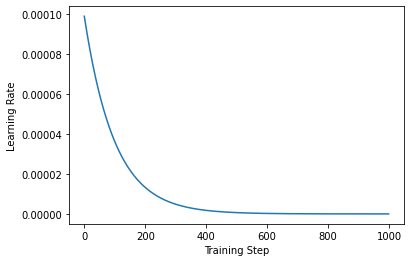

In [25]:
from torch.optim.lr_scheduler import LambdaLR

myoptimizer = Adam(model.parameters(), lr=hparams['lr'])
my_scheduler = LambdaLR(myoptimizer, lr_lambda = lambda step: 0.99**step) # 원래의 learning rate에 0.99^step를 곱한 값으로 learning rate가 조정됩니다. 

lr_history = []
for step in range(1000):
    my_scheduler.step() # Scheduler가 step()를 호출할 때마다 optimizer() 내부의 learning rate가 조정됩니다.
    lr_history.append(myoptimizer.param_groups[0]['lr'])
    
from matplotlib import pyplot
_ = plt.plot(list(range(1000)), lr_history)
plt.ylabel("Learning Rate")
plt.xlabel("Training Step")
plt.show()

- 보다 다양한 scheduling 기법의 활용을 위한 별도의 함수를 구현한 뒤 LambdaLR()의 lr_lambda에 넣어줄 수도 있습니다.
- 이를 통해 아래와 같이 warmup step을 고려한 learning rate scheduler를 구현할 수도 있습니다.

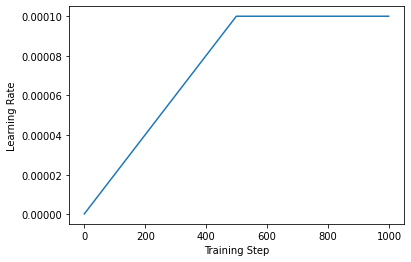

In [26]:
from torch.optim.lr_scheduler import LambdaLR
from functools import partial


def warmup_then_constant(step, warmup_step:int):
    if step <= warmup_step:
        return step / warmup_step
    else:
        return 1

WARMUP_STEP = 500
myoptimizer = Adam(model.parameters(), lr=hparams['lr'])
my_scheduler = LambdaLR(myoptimizer, lr_lambda = partial(warmup_then_constant, warmup_step=WARMUP_STEP)) # 원래의 learning rate에 0.99^step를 곱한 값으로 learning rate가 조정됩니다. 

lr_history = []
for step in range(1000):
    my_scheduler.step() # Scheduler가 step()를 호출할 때마다 optimizer() 내부의 learning rate가 조정됩니다.
    lr_history.append(myoptimizer.param_groups[0]['lr'])
    
from matplotlib import pyplot
_ = plt.plot(list(range(1000)), lr_history)
plt.ylabel("Learning Rate")
plt.xlabel("Training Step")
plt.show()

## Mission. Learning Rate scheduler 구현하기
1. Customized learning rate scheduler 구현하기
  - 구현하는 schduler의 이름은 LinearSchedulerwithWarmup이며, 아래와 같은 특징을 같습니다.
    - 현재 step이 warmup_step보다 작을 경우, 최대 learning rate까지 linear하게 증가
    - 현재 step이 warmup_step보다 클 경우, max_training_step에 도달할떄까지 learning rate가 linear하게 감소
    - 해당 scheduler를 사용하였을 때 step에 따른 learning의 변화는 아래의 그래프와 같습니다.

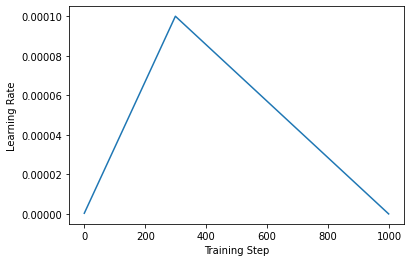

In [27]:
from torch.optim.lr_scheduler import LambdaLR
from functools import partial

def myFunction(step:int, warmup_step:int, max_training_step:int):
    if step <= warmup_step:
        return step/warmup_step
    else:
        return 1-(step-warmup_step)/(max_training_step-warmup_step)


WARMUP_STEP = 300
myoptimizer = Adam(model.parameters(), lr=hparams['lr'])
LinearSchedulerwithWarmup = LambdaLR(myoptimizer, lr_lambda = partial(myFunction, warmup_step=WARMUP_STEP, max_training_step=1000))

lr_history = []
for step in range(1000):
    LinearSchedulerwithWarmup.step() # Scheduler가 step()를 호출할 때마다 optimizer() 내부의 learning rate가 조정됩니다.
    lr_history.append(myoptimizer.param_groups[0]['lr'])
    
from matplotlib import pyplot
_ = plt.plot(list(range(1000)), lr_history)
plt.ylabel("Learning Rate")
plt.xlabel("Training Step")
plt.show()

- 아래의 코드를 통해 Scheduler가 적용된 Trainer를 사용했을 때의 성능을 비교해볼 수 있습니다.
- 성능 향상을 위해 Warmup step, max_training_step 등을 조절하여 성능을 높혀봅시다!

In [ ]:
from tqdm import tqdm
from torch.optim import Adam
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


class MyTrainerwithScheduler:
    def __init__(self, hparams:Dict[str,Any], model, train_dataset, optimizer):
        self.hparams = hparams
        self.model = model
        self.train_dataset = train_dataset
        self.train_loader = DataLoader(self.train_dataset, batch_size=self.hparams['per_device_train_batch_size'],shuffle=True)
        self.optimizer = optimizer
        self.scheduler = LambdaLR(self.optimizer, lr_lambda = partial(myFunction, warmup_step=self.hparams['warmup_steps'], max_training_step=len(self.train_dataset)*self.hparams['num_train_epochs']))
    
    def train(self):
        for epoch in range(self.hparams['num_train_epochs']):
            self._run_epoch()
    
    def _run_epoch(self):
        self.model.train()
        for idx,batch in enumerate(tqdm(self.train_loader)):
            batch = {k:v.to(device) for k,v in batch.items()}
            loss = self.model(**batch)[0]
            loss.backward()
            self.optimizer.step()
            self.scheduler.step() # Optimizer.step() 이후 scheduler.step()을 호출하여 learning rate를 조정합니다.
            self.optimizer.zero_grad()
            if idx%self.hparams['logging_steps']==0: print(loss)
    
    def evaluate(self, eval_dataset):
        eval_loader = DataLoader(self.train_dataset, batch_size=self.hparams['per_device_eval_batch_size'],shuffle=True)
        preds = []
        labels = []
        self.model.eval()
        for idx,batch in enumerate(tqdm(eval_loader)):
            batch = {k:v.to(device) for k,v in batch.items()}
            with torch.no_grad():
                output = self.model(**batch)[1]
                prediction = torch.argmax(output,dim=1).cpu().numpy().tolist()
                preds.extend(prediction)
                labels.extend(batch['labels'].cpu().numpy().tolist())
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
        acc = accuracy_score(labels, preds)
        return {
            'accuracy': acc,
            'f1': f1,
            'precision': precision,
            'recall': recall
        }


model = BertForSequenceClassification.from_pretrained(MODEL_NAME)
model.to(device)
optimizer = Adam(model.parameters(), lr=hparams['lr'])
trainer = MyTrainerwithScheduler(hparams,model,train_dataset,optimizer)
trainer.train()
performance = trainer.evaluate(test_dataset)        
print(performance)

    

# Label smoothing 구현하기

지금까지는 모델의 학습을 위한 Loss function으로써 BertForSequenceClassification 내부에 구현된 CrossEntropyLoss를 사용하였으며, 이때 모델이 맞추고자 하는 정답은 Hard label의 형태로 사용되었습니다.
  - Hard label: 정답 클래스는 1, 나머지 클래스는 0으로 구성된 레이블. 
 
이번에는 딥러닝 모델의 over-confidence 문제를 개선하기 위해 자주 사용되는 레이블 스무딩(label smoothing)을 직접 구현하고, 이를 학습에 이용해봅시다.
- Label smoothing: 정답이 아닌 클래스에도 0이 아닌 값을 부여하여 구성된 soft label을 정답으로 활용하는 학습 방법입니다. $K$개의 클래스에 대해 스무딩 파라미터(smoothing parameter) $\alpha$가 있을 때, 정답이 아닌 클래스들의 레이블 값은 $\alpha/K$만큼 더해지고 정답 클래스의 레이블 값은 $K - \alpha/K$만큼 감소됩니다.


예를 들어, 레이블이 총 2개의 클래스로 구성되어 있고 ($K$=2) 그 중 두 번째 클래스가 정답이며 $\alpha$가 0.1일 때의 hard label과 soft label은 아래와 같습니다.
  
$y^{hard} = [0.0, 1.0]$

$y^{soft} = [0.05, 0.95]$

이에 대한 모델의 예측 확률 $p_k=[0.2, 0.8]$일 때, Hard label과 soft label을 활용하여 계산한 loss는 각각 아래와 같습니다.

$L_{hard} = \sum_{k=1}^{K}-y^{hard}_klog(p_k) = - 1 * log(0.8) = 0.22$

$L_{soft} = \sum_{k=1}^{K}-y^{soft}_klog(p_k) = -0.05 * log(0.2) - 0.95 * log(0.8) = 0.29$

- $y_k$ = $k$번째 클래스에 대한 레이블 값

이와 같은 label smoothing은 정답이 아닌 클래스에 대해서도 어느 정도의 레이블 값을 부여함으로써 딥러닝 모델의 과신(over-confidence) 문제를 해결하는데에 도움이 된다고 알려져있습니다. 

PyTorch를 이용하여 label smoothing을 구현하는 예시는 아래와 같습니다.


In [29]:
import torch
from torch import nn
import torch.nn.functional as F

pred = torch.rand(4, 3) # batch_size * total_class
target = torch.tensor([1, 2, 2, 0])
epsilon = 0.1
K = pred.size(-1) # 전체 클래스의 갯수

log_probs = F.log_softmax(pred, dim=-1)
avg_log_probs = (-log_probs).sum(-1).mean()
ce_loss = F.nll_loss(log_probs, target)
print("Cross entropy with hard label: {}".format(ce_loss))

ce_loss_w_soft_label = (1-epsilon) * ce_loss + epsilon / K * (avg_log_probs)
print("Cross entropy with soft label: {}".format(ce_loss_w_soft_label))


Cross entropy with hard label: 1.074031949043274
Cross entropy with soft label: 1.07729971408844


위의 코드를 학습에 사용하기 용이하도록 클래스화한 결과는 아래와 같습니다.

In [30]:
class CrossEntropywithLabelSmoothing(nn.Module):
    def __init__(self, epsilon: float = 0.1):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, preds, target):
        assert preds.size(0) == target.size(0)
        K = pred.size(-1) # 전체 클래스의 갯수
        log_probs = F.log_softmax(pred, dim=-1)
        avg_log_probs = (-log_probs).sum(-1).mean()
        ce_loss = F.nll_loss(log_probs, target)
        ce_loss_w_soft_label = (1-self.epsilon) * ce_loss + self.epsilon / K * (avg_log_probs)
        return ce_loss_w_soft_label

pred = torch.rand(4, 3, requires_grad=True).to("cuda") # batch_size * total_class
target = torch.tensor([1, 2, 2, 0]).to("cuda")
epsilon = 0.1

loss_func = CrossEntropywithLabelSmoothing(epsilon=epsilon)
loss = loss_func(pred, target)
print(loss)


tensor(1.1514, device='cuda:0', grad_fn=<AddBackward0>)


이제 기존의 학습 파이프라인에 Label smothing을 적용한 Cross entropy을 적용하고 모델을 학습해 보세요!